In [37]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from scipy.stats import entropy
from collections import defaultdict
import argparse
from matplotlib import pyplot as plt
import random, torch

random.seed(0) # Set seed for NumPy
np.random.seed(0) # Set seed for PyTorch (for both CPU and GPU)
torch.manual_seed(0)
if torch.cuda.is_available(): 
    torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

train_df = pd.read_csv('train_dataset/metadata.csv')
test_df = pd.read_csv('test_dataset/metadata.csv')
val_df = pd.read_csv('validation_dataset/metadata.csv')

In [38]:
class_mapping = {
    "actinic keratosis": 0,
    "basal cell carcinoma": 1,
    "dermatofibroma": 2,
    "melanoma": 3,
    "nevus": 4,
    "pigmented benign keratosis": 5,
    "squamous cell carcinoma": 6,
    "vascular lesion":7
}
class_mapping

{'actinic keratosis': 0,
 'basal cell carcinoma': 1,
 'dermatofibroma': 2,
 'melanoma': 3,
 'nevus': 4,
 'pigmented benign keratosis': 5,
 'squamous cell carcinoma': 6,
 'vascular lesion': 7}

In [39]:
from PIL import Image
import os

import torchvision.transforms as transforms

# Define image transformations (resize, convert to tensor, and normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize images to 224x224 (matching ResNet input size)
    transforms.ToTensor()
])

class Dataset():
    def __init__(self, dataframe, transform, train='train'):
        self.dataframe=dataframe
        self.train = train
        self.transform = transform
        self.path_to_image=self._create_path_to_image_dict()
        self.paths=list(self.path_to_image.keys())
        self.labels=list(self.path_to_image.values())

    def _create_path_to_image_dict(self):
      path_to_image={}
      for index,row in self.dataframe.iterrows():
        if self.train == 'train':
          img_path = os.path.join('train_dataset/',row['isic_id']+'.jpg')
        elif self.train == 'test':
          img_path = os.path.join('test_dataset/',row['isic_id']+'.jpg')
        else:
            img_path = os.path.join('validation_dataset/',row['isic_id']+'.jpg')
        label=row['diagnosis']
        path_to_image[img_path]=label
      return path_to_image

    def __len__(self):
        return len(self.paths)

    def __getitem__(self,index):
        img_path=self.paths[index]
        img_label=self.labels[index]
        image=Image.open(img_path)
        image=self.transform(image)
        if self.train == 'val':
            return image, class_mapping[img_label], index
        return image, img_label, index

In [40]:
train_df = Dataset(train_df, transform)
val_df = Dataset(val_df, transform,train='val')
test_df = Dataset(test_df, transform,train='test')

In [41]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.optim import Adam

# Load pre-trained ResNet50 model from torchvision
base_model = models.resnet50(pretrained=True)

num_classes = 8  # Adjust this based on your dataset
base_model.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(base_model.fc.in_features, 128),  # Add a fully connected layer
    nn.ReLU(),
    nn.Linear(128, num_classes),  # Final layer with number of classes
    nn.Softmax(dim=1)  # Softmax activation for multi-class classification
)

for param in base_model.parameters():
    param.requires_grad = False  # Freeze all layers except the fully connected ones

# Unfreeze the final fully connected layer
for param in base_model.fc.parameters():
    param.requires_grad = True
    
loss_f = nn.CrossEntropyLoss()
optimizer = Adam(base_model.fc.parameters(), lr=0.0008)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device)
x = 5

/anaconda/envs/py38_default/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [42]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 4  # Adjust based on your memory and hardware
val_loader = DataLoader(val_df, batch_size=batch_size, shuffle=False)

In [43]:
from sklearn.cluster import KMeans
import numpy as np
from transformers import ViTFeatureExtractor, ViTModel

class ActiveLearningPipeline:
    def __init__(self, model,
                 available_pool_indices,
                 train_indices,
                 test_indices,
                 selection_criterion,
                 iterations,
                 budget_per_iter,
                 num_epochs):
        self.model = model
        self.iterations = iterations
        self.budget_per_iter = budget_per_iter
        self.available_pool_indices = available_pool_indices
        self.train_indices = train_indices
        self.test_indices = test_indices
        self.selection_criterion = selection_criterion
        if self.selection_criterion == 'random':
          self.train_indices = []
        self.num_epochs = num_epochs
        self.pool_features = []
        self.pool_indices = []

    def run_pipeline(self):
        """
        Run the active learning pipeline
        :return
        accuracy_scores: list, accuracy scores at each iteration
        """
        accuracy_scores = []
        self._get_features()
        for iteration in range(self.iterations):
            print(f"--------- Number of Iteration {iteration} ---------")
            if self.selection_criterion == 'random':
                self._random_sampling()
            elif self.selection_criterion == 'kmeans_num_classes':
                self._kmeans_sampling()
            else:
              self._custom_sampling(iteration)
            
            train_images = [train_df.__getitem__(index)[0] for index in self.train_indices]
            label_df = [class_mapping[train_df.__getitem__(index)[1]] for index in self.train_indices]
            self._train_model(train_images, label_df)
            self.model.load_state_dict(torch.load(f"best_{self.selection_criterion}_model.pth"))
            accuracy = self._evaluate_model()
            accuracy_scores.append(accuracy)
        return accuracy_scores
        
    def calculate_class_weights(self, label_counts, num_classes=8):
        total_samples = sum(label_counts.values())
        class_weights = torch.zeros(num_classes)
        
        for cls in range(num_classes):
            if cls in label_counts:
                class_weights[cls] = total_samples / (num_classes * label_counts[cls])
            else:
                class_weights[cls] = 1.0  # Handle the case where a class has zero samples in the current epoch
    
        return class_weights
    
    def _train_model(self, train_images, label_df):
      label_counts = defaultdict(int)
      for label in label_df:
                label_counts[label] += 1
      class_weights = self.calculate_class_weights(label_counts, 8).to(device)
      loss_f = nn.CrossEntropyLoss(weight=class_weights)
        
      train_images_tensor = torch.stack(train_images)
      label_df_tensor = torch.tensor(label_df)
      train_dataset = TensorDataset(train_images_tensor, label_df_tensor)

      batch_size = 32
      train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      best_acc = 0
      for epoch in range(self.num_epochs):
                self.model.train()
                running_loss = 0.0  # Track the running loss
                correct_predictions = 0
                total_predictions = 0
                # Training loop
                for inputs, labels in train_loader:
                    inputs = inputs
                    inputs= inputs.to(device)
                    labels = torch.tensor(labels).to(device)
                    
                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass
                    outputs = self.model(inputs)
                    loss = loss_f(outputs, labels)

                    # Backward pass and optimization
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()
        
                    # Calculate accuracy
                    _, preds = torch.max(outputs, 1)
                    correct_predictions += torch.sum(preds == labels)
                    total_predictions += inputs.shape[0]

                # Print loss and accuracy at the end of each epoch
                epoch_loss = running_loss / len(train_loader)
                epoch_acc = correct_predictions.double() / total_predictions
                print(f'Epoch [{epoch+1}/{self.num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
          
                val_acc = self._check_model()
                if val_acc > best_acc: 
                    best_acc = val_acc
                    torch.save(self.model.state_dict(), f"best_{self.selection_criterion}_model.pth")
      print("--"*30)
        
    def _check_model(self):
        self.model.eval()
        running_corrects = 0
        total_predictions = 0.0
    
        with torch.no_grad():
            for inputs, labels, _ in val_loader:
                inputs = inputs.to(device)
                labels = torch.tensor(labels).to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                running_corrects += torch.sum(preds == labels)
                total_predictions += inputs.shape[0]
        val_acc = running_corrects.double() / total_predictions
        return val_acc.item()
        
    def _evaluate_model(self):
        """
        Evaluate the model
        :return:
        accuracy: float, accuracy of the model
        """
        self.model.eval()
        running_corrects = 0
        test_images_tensor = torch.stack(test_images)
        label_df_tensor = torch.tensor(test_label_df)
        test_dataset = TensorDataset(test_images_tensor, label_df_tensor)
        batch_size = 32  # Adjust based on your memory and hardware
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        total_predictions = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = torch.tensor(labels).to(device)

                outputs = model(inputs)
                # outputs = outputs.logits
                _, preds = torch.max(outputs, 1)

                running_corrects += torch.sum(preds == labels)
                total_predictions += inputs.shape[0]
        test_acc = running_corrects.double() / total_predictions
        return test_acc.item()

    def _random_sampling(self):
      selected_indices = np.random.choice(self.available_pool_indices, self.budget_per_iter, replace=False)
      selected_indices = selected_indices.tolist()
      self.train_indices = self.train_indices + selected_indices

      available_pool_set = set(self.available_pool_indices)
      train_set = set(self.train_indices)
      self.available_pool_indices = list(available_pool_set - train_set)

    def extract_vae_features(self, dataloader, model, feature_extractor):
        features_list = []
        indices_list = []
        
        with torch.no_grad():
            for images, indices in dataloader:
                # images = images.to(device)  # Move images to GPU if available
                images_list = [transforms.ToPILImage()(img) for img in images]
                inputs = feature_extractor(images=images_list, return_tensors="pt")
                with torch.no_grad():
                    outputs = model(**inputs)
                
                x = outputs.last_hidden_state[:, 0, :]
                features_list.append(x.cpu().numpy())
                
                # Collect indices
                indices_list.extend(indices)
                
        # Stack all features into a 2D array (n_samples, hidden_dim)
        features = np.vstack(features_list)
        
        return features, indices_list

    def get_representative_images(self, kmeans, pool_features, pool_indices):
        cluster_to_images = {}
        for i in range(kmeans.n_clusters):
            # Get the indices of all images in the current cluster
            cluster_indices = np.where(kmeans.labels_ == i)[0]
            
            # Extract features of the images in the current cluster
            cluster_features = pool_features[cluster_indices]
            
            # Compute distances between each feature and the cluster centroid
            distances = np.linalg.norm(cluster_features - kmeans.cluster_centers_[i], axis=1)
            
            # Map the cluster number to the index of the representative image
            # nearest_indices = cluster_indices[np.argsort(distances)[:7]]

            # Another approach
            nearest_indices = cluster_indices[np.argsort(distances)[:4]]
            farthest_indices = cluster_indices[np.argsort(distances)[-3:]]
            
            # Map the cluster number to the indices of the top k nearest images
            # cluster_to_images[i] = [pool_indices[idx] for idx in nearest_indices]

            # Another approach
            cluster_to_images[i] = [pool_indices[idx] for idx in nearest_indices] + [pool_indices[idx] for idx in farthest_indices]
        return cluster_to_images
       
    def _get_features(self):
        feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
        model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        
        X_unlabeled = [train_df.__getitem__(index)[0] for index in self.available_pool_indices]
        # Extract latent features using the VAE model
        pool_images_tensor = torch.stack(X_unlabeled)
        pool_indices_tensor = torch.tensor(self.available_pool_indices)
        pool_dataset = TensorDataset(pool_images_tensor, pool_indices_tensor)
    
        batch_size = 32
        pool_loader = DataLoader(pool_dataset, batch_size=batch_size, shuffle=False)
   
        self.pool_features, self.pool_indices = self.extract_vae_features(pool_loader, model, feature_extractor)
        
    def _kmeans_sampling(self):
          
          n_clusters = 8 
          kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0)
          kmeans.fit(self.pool_features)
            
          representative_images = self.get_representative_images(kmeans, self.pool_features, self.pool_indices)
          selected_indices = list(ids.item() for l in representative_images.values() for ids in l) 

          for i in selected_indices:
              index = self.pool_indices.index(i)
              self.pool_features = np.delete(self.pool_features, index, axis=0)
              self.pool_indices.pop(index)
          
          self.train_indices = self.train_indices + selected_indices
            
          available_pool_set = set(self.available_pool_indices)
          train_set = set(self.train_indices)
          self.available_pool_indices = list(available_pool_set - train_set)




In [44]:
def generate_plot(accuracy_scores_dict):
    """
    Generate a plot
    """
    for criterion, accuracy_scores in accuracy_scores_dict.items():
        plt.plot(range(1, len(accuracy_scores) + 1), accuracy_scores, label=criterion)
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [45]:
available_pool_indices = []
for i in range(len(train_df)):
    image, label, index = train_df[i]
    available_pool_indices.append(index)

test_indices = []
for i in range(len(test_df)):
    image, label, index = test_df[i]
    test_indices.append(index)
test_images = [test_df.__getitem__(index)[0] for index in test_indices]
test_label_df = [class_mapping[test_df.__getitem__(index)[1]] for index in test_indices]

In [46]:
train_indices = [1372,
 1277,
 1255,
 1423,
 2925,
 1963,
 2335,
 1923,
 3791,
 1239,
 909,
 134,
 1547,
 3931,
 2467,
 2832,
 1789,
 3022,
 2424,
 780,
 2412,
 3038,
 2158,
 3335,
 1868,
 1771,
 2015,
 1535,
 710,
 3007]
available_pool_set = set(available_pool_indices)
train_set = set(train_indices)
available_pool_indices = list(available_pool_set - train_set)

In [47]:
# train_indices = []
iterations = 20
budget_per_iter = 60
num_epoch = 15
selection_criteria = ['kmeans_num_classes']
accuracy_scores_dict = defaultdict(list)
model = base_model

/anaconda/envs/py38_default/lib/python3.9/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


--------- Number of Iteration 0 ---------


/tmp/ipykernel_303787/3124605072.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 2.0967, Accuracy: 0.1163


/tmp/ipykernel_303787/3124605072.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 2.0566, Accuracy: 0.3023
Epoch [3/15], Loss: 2.0177, Accuracy: 0.6512
Epoch [4/15], Loss: 1.9716, Accuracy: 0.7093
Epoch [5/15], Loss: 1.9195, Accuracy: 0.7558
Epoch [6/15], Loss: 1.8475, Accuracy: 0.6977
Epoch [7/15], Loss: 1.7747, Accuracy: 0.7674
Epoch [8/15], Loss: 1.7464, Accuracy: 0.8140
Epoch [9/15], Loss: 1.7231, Accuracy: 0.7907
Epoch [10/15], Loss: 1.6887, Accuracy: 0.8023
Epoch [11/15], Loss: 1.6067, Accuracy: 0.8721
Epoch [12/15], Loss: 1.6513, Accuracy: 0.8256
Epoch [13/15], Loss: 1.5940, Accuracy: 0.8721
Epoch [14/15], Loss: 1.5405, Accuracy: 0.8372
Epoch [15/15], Loss: 1.5358, Accuracy: 0.8605
------------------------------------------------------------


/tmp/ipykernel_303787/3124605072.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 1 ---------


/tmp/ipykernel_303787/3124605072.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.7240, Accuracy: 0.7183


/tmp/ipykernel_303787/3124605072.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.7111, Accuracy: 0.7042
Epoch [3/15], Loss: 1.7274, Accuracy: 0.7324
Epoch [4/15], Loss: 1.6821, Accuracy: 0.7394
Epoch [5/15], Loss: 1.6544, Accuracy: 0.7746
Epoch [6/15], Loss: 1.6763, Accuracy: 0.7676
Epoch [7/15], Loss: 1.6543, Accuracy: 0.7817
Epoch [8/15], Loss: 1.6265, Accuracy: 0.7606
Epoch [9/15], Loss: 1.6705, Accuracy: 0.7042
Epoch [10/15], Loss: 1.6092, Accuracy: 0.7465
Epoch [11/15], Loss: 1.6207, Accuracy: 0.8028
Epoch [12/15], Loss: 1.5828, Accuracy: 0.8099
Epoch [13/15], Loss: 1.5776, Accuracy: 0.8239
Epoch [14/15], Loss: 1.5988, Accuracy: 0.8169
Epoch [15/15], Loss: 1.5656, Accuracy: 0.8028
------------------------------------------------------------


/tmp/ipykernel_303787/3124605072.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 2 ---------


/tmp/ipykernel_303787/3124605072.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.6951, Accuracy: 0.6364


/tmp/ipykernel_303787/3124605072.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.7499, Accuracy: 0.6616
Epoch [3/15], Loss: 1.6747, Accuracy: 0.7525
Epoch [4/15], Loss: 1.6684, Accuracy: 0.7020
Epoch [5/15], Loss: 1.7010, Accuracy: 0.7273
Epoch [6/15], Loss: 1.6635, Accuracy: 0.6717
Epoch [7/15], Loss: 1.6886, Accuracy: 0.6616
Epoch [8/15], Loss: 1.6647, Accuracy: 0.7222
Epoch [9/15], Loss: 1.6520, Accuracy: 0.7273
Epoch [10/15], Loss: 1.5838, Accuracy: 0.7727
Epoch [11/15], Loss: 1.6017, Accuracy: 0.7576
Epoch [12/15], Loss: 1.6214, Accuracy: 0.7525
Epoch [13/15], Loss: 1.5665, Accuracy: 0.7626
Epoch [14/15], Loss: 1.6023, Accuracy: 0.7576
Epoch [15/15], Loss: 1.6570, Accuracy: 0.7172
------------------------------------------------------------


/tmp/ipykernel_303787/3124605072.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 3 ---------


/tmp/ipykernel_303787/3124605072.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.6805, Accuracy: 0.6693


/tmp/ipykernel_303787/3124605072.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.7187, Accuracy: 0.6850
Epoch [3/15], Loss: 1.6779, Accuracy: 0.7165
Epoch [4/15], Loss: 1.6699, Accuracy: 0.7047
Epoch [5/15], Loss: 1.6297, Accuracy: 0.7402
Epoch [6/15], Loss: 1.6475, Accuracy: 0.7441
Epoch [7/15], Loss: 1.6659, Accuracy: 0.7520
Epoch [8/15], Loss: 1.6416, Accuracy: 0.7441
Epoch [9/15], Loss: 1.6196, Accuracy: 0.7638
Epoch [10/15], Loss: 1.6073, Accuracy: 0.7874
Epoch [11/15], Loss: 1.5973, Accuracy: 0.7835
Epoch [12/15], Loss: 1.6271, Accuracy: 0.7559
Epoch [13/15], Loss: 1.6140, Accuracy: 0.7953
Epoch [14/15], Loss: 1.6010, Accuracy: 0.8031
Epoch [15/15], Loss: 1.5925, Accuracy: 0.8150
------------------------------------------------------------


/tmp/ipykernel_303787/3124605072.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 4 ---------


/tmp/ipykernel_303787/3124605072.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.6940, Accuracy: 0.7258


/tmp/ipykernel_303787/3124605072.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.6916, Accuracy: 0.7032
Epoch [3/15], Loss: 1.6717, Accuracy: 0.7032
Epoch [4/15], Loss: 1.6991, Accuracy: 0.6355
Epoch [5/15], Loss: 1.6714, Accuracy: 0.7129
Epoch [6/15], Loss: 1.6458, Accuracy: 0.7452
Epoch [7/15], Loss: 1.6669, Accuracy: 0.7226
Epoch [8/15], Loss: 1.6383, Accuracy: 0.7226
Epoch [9/15], Loss: 1.6452, Accuracy: 0.7581
Epoch [10/15], Loss: 1.6174, Accuracy: 0.7645
Epoch [11/15], Loss: 1.6353, Accuracy: 0.7677
Epoch [12/15], Loss: 1.6243, Accuracy: 0.7677
Epoch [13/15], Loss: 1.6185, Accuracy: 0.7645
Epoch [14/15], Loss: 1.5850, Accuracy: 0.7355
Epoch [15/15], Loss: 1.5507, Accuracy: 0.7710
------------------------------------------------------------


/tmp/ipykernel_303787/3124605072.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 5 ---------


/tmp/ipykernel_303787/3124605072.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.6976, Accuracy: 0.7077


/tmp/ipykernel_303787/3124605072.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.7052, Accuracy: 0.6967
Epoch [3/15], Loss: 1.6933, Accuracy: 0.7186
Epoch [4/15], Loss: 1.6826, Accuracy: 0.7268
Epoch [5/15], Loss: 1.6841, Accuracy: 0.7240
Epoch [6/15], Loss: 1.6736, Accuracy: 0.6940
Epoch [7/15], Loss: 1.6464, Accuracy: 0.7049
Epoch [8/15], Loss: 1.6544, Accuracy: 0.7295
Epoch [9/15], Loss: 1.6601, Accuracy: 0.7322
Epoch [10/15], Loss: 1.6377, Accuracy: 0.7268
Epoch [11/15], Loss: 1.6239, Accuracy: 0.7650
Epoch [12/15], Loss: 1.6478, Accuracy: 0.7350
Epoch [13/15], Loss: 1.6194, Accuracy: 0.7541
Epoch [14/15], Loss: 1.6511, Accuracy: 0.7295
Epoch [15/15], Loss: 1.6673, Accuracy: 0.7186
------------------------------------------------------------


/tmp/ipykernel_303787/3124605072.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 6 ---------


/tmp/ipykernel_303787/3124605072.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.6546, Accuracy: 0.7133


/tmp/ipykernel_303787/3124605072.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.6473, Accuracy: 0.7464
Epoch [3/15], Loss: 1.6077, Accuracy: 0.7701
Epoch [4/15], Loss: 1.6160, Accuracy: 0.7275
Epoch [5/15], Loss: 1.6241, Accuracy: 0.7393
Epoch [6/15], Loss: 1.6311, Accuracy: 0.7227
Epoch [7/15], Loss: 1.6333, Accuracy: 0.7607
Epoch [8/15], Loss: 1.6027, Accuracy: 0.7678
Epoch [9/15], Loss: 1.6083, Accuracy: 0.7678
Epoch [10/15], Loss: 1.6285, Accuracy: 0.7346
Epoch [11/15], Loss: 1.5903, Accuracy: 0.7417
Epoch [12/15], Loss: 1.6135, Accuracy: 0.7085
Epoch [13/15], Loss: 1.5900, Accuracy: 0.7678
Epoch [14/15], Loss: 1.5406, Accuracy: 0.8009
Epoch [15/15], Loss: 1.5796, Accuracy: 0.7725
------------------------------------------------------------


/tmp/ipykernel_303787/3124605072.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 7 ---------


/tmp/ipykernel_303787/3124605072.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.6338, Accuracy: 0.6799


/tmp/ipykernel_303787/3124605072.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.6037, Accuracy: 0.7510
Epoch [3/15], Loss: 1.5932, Accuracy: 0.7699
Epoch [4/15], Loss: 1.5512, Accuracy: 0.7531
Epoch [5/15], Loss: 1.5494, Accuracy: 0.7364
Epoch [6/15], Loss: 1.5283, Accuracy: 0.7762
Epoch [7/15], Loss: 1.4890, Accuracy: 0.7803
Epoch [8/15], Loss: 1.4881, Accuracy: 0.7845
Epoch [9/15], Loss: 1.4888, Accuracy: 0.7824
Epoch [10/15], Loss: 1.5024, Accuracy: 0.7615
Epoch [11/15], Loss: 1.4786, Accuracy: 0.7845
Epoch [12/15], Loss: 1.4906, Accuracy: 0.7762
Epoch [13/15], Loss: 1.4601, Accuracy: 0.8033
Epoch [14/15], Loss: 1.4435, Accuracy: 0.8180
Epoch [15/15], Loss: 1.4469, Accuracy: 0.8222
------------------------------------------------------------


/tmp/ipykernel_303787/3124605072.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 8 ---------


/tmp/ipykernel_303787/3124605072.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5131, Accuracy: 0.7584


/tmp/ipykernel_303787/3124605072.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5226, Accuracy: 0.7734
Epoch [3/15], Loss: 1.5041, Accuracy: 0.7734
Epoch [4/15], Loss: 1.5058, Accuracy: 0.7715
Epoch [5/15], Loss: 1.4844, Accuracy: 0.8034
Epoch [6/15], Loss: 1.4967, Accuracy: 0.7697
Epoch [7/15], Loss: 1.4793, Accuracy: 0.7828
Epoch [8/15], Loss: 1.4852, Accuracy: 0.7659
Epoch [9/15], Loss: 1.4564, Accuracy: 0.8052
Epoch [10/15], Loss: 1.4643, Accuracy: 0.8090
Epoch [11/15], Loss: 1.4635, Accuracy: 0.8277
Epoch [12/15], Loss: 1.4509, Accuracy: 0.8090
Epoch [13/15], Loss: 1.4425, Accuracy: 0.8202
Epoch [14/15], Loss: 1.4434, Accuracy: 0.8333
Epoch [15/15], Loss: 1.4412, Accuracy: 0.8296
------------------------------------------------------------


/tmp/ipykernel_303787/3124605072.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 9 ---------


/tmp/ipykernel_303787/3124605072.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5079, Accuracy: 0.7831


/tmp/ipykernel_303787/3124605072.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5337, Accuracy: 0.7576
Epoch [3/15], Loss: 1.5265, Accuracy: 0.7339
Epoch [4/15], Loss: 1.5080, Accuracy: 0.7695
Epoch [5/15], Loss: 1.5052, Accuracy: 0.7593
Epoch [6/15], Loss: 1.4909, Accuracy: 0.8085
Epoch [7/15], Loss: 1.4932, Accuracy: 0.7966
Epoch [8/15], Loss: 1.5130, Accuracy: 0.7610
Epoch [9/15], Loss: 1.5198, Accuracy: 0.6932
Epoch [10/15], Loss: 1.4971, Accuracy: 0.7576
Epoch [11/15], Loss: 1.4768, Accuracy: 0.7983
Epoch [12/15], Loss: 1.4846, Accuracy: 0.7915
Epoch [13/15], Loss: 1.4625, Accuracy: 0.8136
Epoch [14/15], Loss: 1.4795, Accuracy: 0.7797
Epoch [15/15], Loss: 1.4777, Accuracy: 0.7847
------------------------------------------------------------


/tmp/ipykernel_303787/3124605072.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 10 ---------


/tmp/ipykernel_303787/3124605072.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5651, Accuracy: 0.7229


/tmp/ipykernel_303787/3124605072.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5607, Accuracy: 0.7508
Epoch [3/15], Loss: 1.5398, Accuracy: 0.7523
Epoch [4/15], Loss: 1.5550, Accuracy: 0.7461
Epoch [5/15], Loss: 1.5563, Accuracy: 0.7198
Epoch [6/15], Loss: 1.5219, Accuracy: 0.7570
Epoch [7/15], Loss: 1.5869, Accuracy: 0.6053
Epoch [8/15], Loss: 1.5388, Accuracy: 0.7229
Epoch [9/15], Loss: 1.5088, Accuracy: 0.7771
Epoch [10/15], Loss: 1.5060, Accuracy: 0.7941
Epoch [11/15], Loss: 1.5048, Accuracy: 0.7663
Epoch [12/15], Loss: 1.5204, Accuracy: 0.7647
Epoch [13/15], Loss: 1.5234, Accuracy: 0.7167
Epoch [14/15], Loss: 1.4812, Accuracy: 0.8003
Epoch [15/15], Loss: 1.4756, Accuracy: 0.8065
------------------------------------------------------------


/tmp/ipykernel_303787/3124605072.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 11 ---------


/tmp/ipykernel_303787/3124605072.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5681, Accuracy: 0.7208


/tmp/ipykernel_303787/3124605072.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5772, Accuracy: 0.6909
Epoch [3/15], Loss: 1.5432, Accuracy: 0.7650
Epoch [4/15], Loss: 1.5311, Accuracy: 0.7507
Epoch [5/15], Loss: 1.5257, Accuracy: 0.7792
Epoch [6/15], Loss: 1.5100, Accuracy: 0.7821
Epoch [7/15], Loss: 1.5245, Accuracy: 0.7536
Epoch [8/15], Loss: 1.5374, Accuracy: 0.7707
Epoch [9/15], Loss: 1.5060, Accuracy: 0.7735
Epoch [10/15], Loss: 1.4886, Accuracy: 0.7906
Epoch [11/15], Loss: 1.5034, Accuracy: 0.7664
Epoch [12/15], Loss: 1.5060, Accuracy: 0.7792
Epoch [13/15], Loss: 1.4883, Accuracy: 0.7863
Epoch [14/15], Loss: 1.4903, Accuracy: 0.7991
Epoch [15/15], Loss: 1.4935, Accuracy: 0.7877
------------------------------------------------------------


/tmp/ipykernel_303787/3124605072.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 12 ---------


/tmp/ipykernel_303787/3124605072.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5178, Accuracy: 0.7718


/tmp/ipykernel_303787/3124605072.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.4990, Accuracy: 0.7784
Epoch [3/15], Loss: 1.4946, Accuracy: 0.7968
Epoch [4/15], Loss: 1.4959, Accuracy: 0.7876
Epoch [5/15], Loss: 1.4894, Accuracy: 0.7995
Epoch [6/15], Loss: 1.4955, Accuracy: 0.7955
Epoch [7/15], Loss: 1.4992, Accuracy: 0.7902
Epoch [8/15], Loss: 1.4711, Accuracy: 0.8127
Epoch [9/15], Loss: 1.4729, Accuracy: 0.8179
Epoch [10/15], Loss: 1.5000, Accuracy: 0.7982
Epoch [11/15], Loss: 1.4859, Accuracy: 0.7850
Epoch [12/15], Loss: 1.4906, Accuracy: 0.8127
Epoch [13/15], Loss: 1.4666, Accuracy: 0.8166
Epoch [14/15], Loss: 1.4710, Accuracy: 0.8021
Epoch [15/15], Loss: 1.5013, Accuracy: 0.7942
------------------------------------------------------------


/tmp/ipykernel_303787/3124605072.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 13 ---------


/tmp/ipykernel_303787/3124605072.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.4927, Accuracy: 0.7973


/tmp/ipykernel_303787/3124605072.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.4839, Accuracy: 0.8170
Epoch [3/15], Loss: 1.4880, Accuracy: 0.7973
Epoch [4/15], Loss: 1.4896, Accuracy: 0.7899
Epoch [5/15], Loss: 1.4889, Accuracy: 0.7912
Epoch [6/15], Loss: 1.4834, Accuracy: 0.8145
Epoch [7/15], Loss: 1.4626, Accuracy: 0.8292
Epoch [8/15], Loss: 1.4747, Accuracy: 0.8071
Epoch [9/15], Loss: 1.5026, Accuracy: 0.7948
Epoch [10/15], Loss: 1.4742, Accuracy: 0.8145
Epoch [11/15], Loss: 1.4748, Accuracy: 0.8157
Epoch [12/15], Loss: 1.4732, Accuracy: 0.8034
Epoch [13/15], Loss: 1.4648, Accuracy: 0.8378
Epoch [14/15], Loss: 1.4858, Accuracy: 0.7985
Epoch [15/15], Loss: 1.4593, Accuracy: 0.8243
------------------------------------------------------------


/tmp/ipykernel_303787/3124605072.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 14 ---------


/tmp/ipykernel_303787/3124605072.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5086, Accuracy: 0.7678


/tmp/ipykernel_303787/3124605072.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5033, Accuracy: 0.8034
Epoch [3/15], Loss: 1.4812, Accuracy: 0.7690
Epoch [4/15], Loss: 1.4865, Accuracy: 0.7782
Epoch [5/15], Loss: 1.4838, Accuracy: 0.7885
Epoch [6/15], Loss: 1.4868, Accuracy: 0.7609
Epoch [7/15], Loss: 1.4648, Accuracy: 0.8023
Epoch [8/15], Loss: 1.4807, Accuracy: 0.7954
Epoch [9/15], Loss: 1.4964, Accuracy: 0.7609
Epoch [10/15], Loss: 1.4772, Accuracy: 0.8046
Epoch [11/15], Loss: 1.4634, Accuracy: 0.8115
Epoch [12/15], Loss: 1.4683, Accuracy: 0.7805
Epoch [13/15], Loss: 1.4502, Accuracy: 0.8046
Epoch [14/15], Loss: 1.4674, Accuracy: 0.8184
Epoch [15/15], Loss: 1.4894, Accuracy: 0.7828
------------------------------------------------------------


/tmp/ipykernel_303787/3124605072.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 15 ---------


/tmp/ipykernel_303787/3124605072.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5016, Accuracy: 0.7711


/tmp/ipykernel_303787/3124605072.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.4923, Accuracy: 0.7927
Epoch [3/15], Loss: 1.4742, Accuracy: 0.8013
Epoch [4/15], Loss: 1.4867, Accuracy: 0.7991
Epoch [5/15], Loss: 1.4953, Accuracy: 0.7851
Epoch [6/15], Loss: 1.4783, Accuracy: 0.7937
Epoch [7/15], Loss: 1.4683, Accuracy: 0.8121
Epoch [8/15], Loss: 1.4720, Accuracy: 0.8121
Epoch [9/15], Loss: 1.4715, Accuracy: 0.7905
Epoch [10/15], Loss: 1.4752, Accuracy: 0.8002
Epoch [11/15], Loss: 1.4555, Accuracy: 0.8153
Epoch [12/15], Loss: 1.4658, Accuracy: 0.8110
Epoch [13/15], Loss: 1.4605, Accuracy: 0.8251
Epoch [14/15], Loss: 1.4488, Accuracy: 0.8207
Epoch [15/15], Loss: 1.4527, Accuracy: 0.8186
------------------------------------------------------------


/tmp/ipykernel_303787/3124605072.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 16 ---------


/tmp/ipykernel_303787/3124605072.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5071, Accuracy: 0.7770


/tmp/ipykernel_303787/3124605072.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5010, Accuracy: 0.7566
Epoch [3/15], Loss: 1.4897, Accuracy: 0.7902
Epoch [4/15], Loss: 1.4815, Accuracy: 0.7811
Epoch [5/15], Loss: 1.4992, Accuracy: 0.7770
Epoch [6/15], Loss: 1.4864, Accuracy: 0.7770
Epoch [7/15], Loss: 1.4764, Accuracy: 0.8035
Epoch [8/15], Loss: 1.4627, Accuracy: 0.8116
Epoch [9/15], Loss: 1.4623, Accuracy: 0.8075
Epoch [10/15], Loss: 1.4761, Accuracy: 0.7851
Epoch [11/15], Loss: 1.4548, Accuracy: 0.8065
Epoch [12/15], Loss: 1.4722, Accuracy: 0.7953
Epoch [13/15], Loss: 1.4570, Accuracy: 0.8065
Epoch [14/15], Loss: 1.4577, Accuracy: 0.8218
Epoch [15/15], Loss: 1.4979, Accuracy: 0.7760
------------------------------------------------------------


/tmp/ipykernel_303787/3124605072.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 17 ---------


/tmp/ipykernel_303787/3124605072.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5005, Accuracy: 0.7649


/tmp/ipykernel_303787/3124605072.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.4792, Accuracy: 0.7948
Epoch [3/15], Loss: 1.4873, Accuracy: 0.7784
Epoch [4/15], Loss: 1.4987, Accuracy: 0.7909
Epoch [5/15], Loss: 1.4609, Accuracy: 0.8112
Epoch [6/15], Loss: 1.4661, Accuracy: 0.8054
Epoch [7/15], Loss: 1.4651, Accuracy: 0.8150
Epoch [8/15], Loss: 1.4756, Accuracy: 0.7881
Epoch [9/15], Loss: 1.4891, Accuracy: 0.7890
Epoch [10/15], Loss: 1.4664, Accuracy: 0.8015
Epoch [11/15], Loss: 1.4665, Accuracy: 0.7900
Epoch [12/15], Loss: 1.4687, Accuracy: 0.8170
Epoch [13/15], Loss: 1.4691, Accuracy: 0.8073
Epoch [14/15], Loss: 1.4959, Accuracy: 0.7803
Epoch [15/15], Loss: 1.4609, Accuracy: 0.8092
------------------------------------------------------------


/tmp/ipykernel_303787/3124605072.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 18 ---------


/tmp/ipykernel_303787/3124605072.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5101, Accuracy: 0.7642


/tmp/ipykernel_303787/3124605072.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5142, Accuracy: 0.7651
Epoch [3/15], Loss: 1.5066, Accuracy: 0.7724
Epoch [4/15], Loss: 1.5119, Accuracy: 0.7495
Epoch [5/15], Loss: 1.4948, Accuracy: 0.7697
Epoch [6/15], Loss: 1.5160, Accuracy: 0.7386
Epoch [7/15], Loss: 1.4901, Accuracy: 0.7761
Epoch [8/15], Loss: 1.4792, Accuracy: 0.8044
Epoch [9/15], Loss: 1.4857, Accuracy: 0.7687
Epoch [10/15], Loss: 1.4852, Accuracy: 0.7934
Epoch [11/15], Loss: 1.4877, Accuracy: 0.7907
Epoch [12/15], Loss: 1.4936, Accuracy: 0.7633
Epoch [13/15], Loss: 1.4665, Accuracy: 0.8108
Epoch [14/15], Loss: 1.4829, Accuracy: 0.7916
Epoch [15/15], Loss: 1.4597, Accuracy: 0.8062
------------------------------------------------------------


/tmp/ipykernel_303787/3124605072.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 19 ---------


/tmp/ipykernel_303787/3124605072.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.4891, Accuracy: 0.7791


/tmp/ipykernel_303787/3124605072.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.4787, Accuracy: 0.8026
Epoch [3/15], Loss: 1.4687, Accuracy: 0.7948
Epoch [4/15], Loss: 1.4867, Accuracy: 0.7843
Epoch [5/15], Loss: 1.4682, Accuracy: 0.8078
Epoch [6/15], Loss: 1.4983, Accuracy: 0.7713
Epoch [7/15], Loss: 1.4787, Accuracy: 0.7965
Epoch [8/15], Loss: 1.4693, Accuracy: 0.8113
Epoch [9/15], Loss: 1.4553, Accuracy: 0.8243
Epoch [10/15], Loss: 1.4695, Accuracy: 0.8043
Epoch [11/15], Loss: 1.4703, Accuracy: 0.8139
Epoch [12/15], Loss: 1.4651, Accuracy: 0.8122
Epoch [13/15], Loss: 1.4598, Accuracy: 0.8078
Epoch [14/15], Loss: 1.4679, Accuracy: 0.8122
Epoch [15/15], Loss: 1.4600, Accuracy: 0.8113
------------------------------------------------------------


/tmp/ipykernel_303787/3124605072.py:153: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


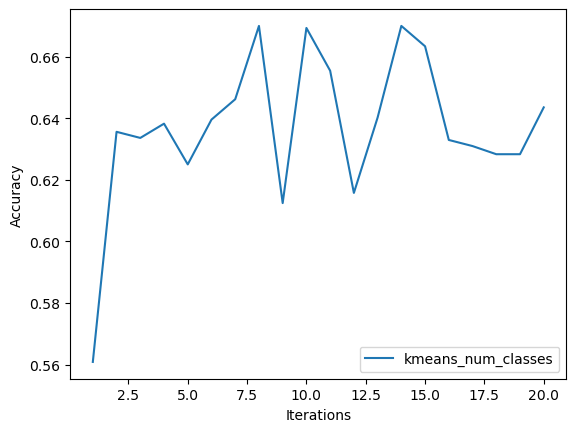

In [48]:
for criterion in selection_criteria:
    AL_class = ActiveLearningPipeline(model=model,
                                      test_indices=test_indices,
                                      available_pool_indices=available_pool_indices,
                                      train_indices=train_indices,
                                      selection_criterion=criterion,
                                      iterations=iterations,
                                      budget_per_iter=budget_per_iter,
                                      num_epochs=num_epoch)
    accuracy_scores_dict[criterion] = AL_class.run_pipeline()
generate_plot(accuracy_scores_dict)

In [49]:
accuracy_scores_dict

defaultdict(list,
            {'kmeans_num_classes': [0.5608465608465608,
              0.6355820105820106,
              0.6335978835978836,
              0.6382275132275131,
              0.625,
              0.6395502645502645,
              0.6461640211640212,
              0.6699735449735449,
              0.6124338624338624,
              0.6693121693121693,
              0.6554232804232804,
              0.6157407407407407,
              0.6402116402116402,
              0.6699735449735449,
              0.6633597883597884,
              0.6329365079365079,
              0.6309523809523809,
              0.6283068783068783,
              0.6283068783068783,
              0.6435185185185185]})

In [ ]:
# kmeans 8 nearst 7 0.6355820105820106
# kmeans 8 nearst 4 farthest 3 0.669